### A random forest model to predict the artist (Modest Mouse or Violent Femmes) by a snippet of lyrics:

In [4]:
# import libraries:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import time
import glob
import os
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# get linkslist from URL, save as html to disk and return as text_file: 

def get_linklist__to_disk(URL:str, html_filename:str):
    
    """scrape linklist from url, 
       save html.file to disk, returns textfile of html"""
    
    response= requests.get(URL)
    print(response.status_code)
    html_file = response.text
    with open(f'{html_filename}.html', 'w') as file:
        file.write(html_file)
    return html_file 

In [6]:
# get linklist for modest mouse, save to disk and return as text_file :

modest_html = get_linklist__to_disk("https://www.lyrics.com/artist/Modest-Mouse/200044", "modest")

200


In [7]:
# get linklist for violent femmes, save to disk and return as text_file :

violent_html = get_linklist__to_disk("https://www.lyrics.com/artist/Violent-Femmes/5767", "violent")

200


#### extract songlinks  with regEx/BeautifulSoup, complete URL and check for duplicates: 

#### Violent femmes

In [8]:
# RegEx pattern: 
pattern_vf = 'href="(\/lyric.+?)"' 

In [9]:
def linklist_url_complete(pattern, textfilename):
    
    """ returns list with complete URLs of songlinks"""
    
    songlist = re.findall(pattern, textfilename)
    complete =[]
    #complete links in list with missing URL part:
    for link in songlist: 
        complete.append("https://www.lyrics.com" + link)
    return complete

In [10]:
songs_vf = linklist_url_complete(pattern_vf, violent_html)

In [11]:
# check for duplicate files:             
def check_dupes(linklist):


    s = set()
    for item in linklist:
        s.add(item)
    if (len(linklist)-(len(s)) == 0):
                         print("no duplicates")
    else:
                         print("duplicates found")
   

In [12]:
check_dupes(songs_vf)

no duplicates


#### Modest Mouse 

In [13]:
#create beautiful soup object:
modest_soup = BeautifulSoup(modest_html, 'html.parser')

In [14]:
# parser:
parser = "soup.find_all(attrs = {'class' : 'tdata-ext'})[0].find_all('tr')"

In [15]:
# create list with complete song links (excluding album links) with beautiful soup:
def linklist_complete_BS(parser:str):
    
    """ get complete URL for MM songs scraped at lyrics.com"""
    songs = []    
    for element in parser:      
   
        try:
            songs.append(element.a.get('href'))
       
        except AttributeError:
            pass
    
    complete =[]
    for link in songs: 
        complete.append("https://www.lyrics.com" + link)
    return complete

In [16]:
songs_mm = linklist_complete_BS(parser)

In [17]:
# check for duplicate files    
check_dupes(songs_mm)

no duplicates


#### get html files for each song

In [18]:
# write function to request all html files in songlink-list and download as html files to disk: 
def get_songs_html(linklist, artist:str, artistinitials:str):
    """scrapes and writes html file for each songlyric to disk"""

    num = 1
    for link in linklist:
    
        response = requests.get(link)
        song_html = response.text
        with open(f'/Users/krystanafoh/lyrics/{artist}/{num}_{artistinitials}_test.html', 'w') as file:
            file.write(song_html)
        num = num + 1
        time.sleep(0.3)

In [19]:
# violent femmes:
#get_songs_html(songs_vf, "violentfemmes", "vf")

In [20]:
# modest mouse:
#get_songs_html(songs_mm, "modestmouse", "mm")

####  extract songlyrics of html files and safe each to textfile: 

In [21]:
def lyrics_to_text(linklist, artist:str, artistinitials:str):
    """extract and safe lyrics of each song to textfile"""
    
    num = 1
    for i in range(len(linklist)):
        
        filename = (f'/Users/krystanafoh/lyrics/{artist}/{num}_{artistinitials}')
# open html file
        html = open(f'{filename}.html')
# create beautiful soup object
        soup = BeautifulSoup(html, 'html.parser')
# get song text
        text = soup.find_all('pre', attrs = {'class' : 'lyric-body'})[0].get_text()
# safe song text to text file: 
        with open(f'{filename}.text', 'w') as file:
            file.write(text)
        num = num + 1

In [22]:
# modest mouse:
#lyrics_to_text(songs_mm, "modestmouse", "mm")

In [23]:
# violent femmes: 
#lyrics_to_text(songs_vf, "violentfemmes", "vf")

#### create lists of strings for each band

In [24]:
def lyrics_to_list(path:str):
    """returns a list of lyricstrings"""

    textfile = glob.glob(os.path.join(path, '*.text'), recursive=False)

    lyrics = []
   
    for file_path in textfile:
        with open(file_path) as f_input:
            lyrics.append(f_input.read())

    return lyrics

In [25]:
# create list of Modest Mouse songtexts: 
path = '/Users/krystanafoh/lyrics/modestmouse/'
list_mm = lyrics_to_list(path)
len(list_mm)

402

In [26]:
# create list of Violent Femmes songtexts: 
path2 = '/Users/krystanafoh/lyrics/violentfemmes/'
list_vf = lyrics_to_list(path2)
len(list_vf)

386

#### create corpus and do test-train-split

In [27]:
CORPUS = list_mm + list_vf

In [28]:
len(CORPUS)

788

In [60]:
labels = ["Modest Mouse"] * len(list_mm) + ["Violent Femmes"] * len(list_vf)

386

In [30]:
X = CORPUS
y = labels

In [31]:
# train-test-split: 
X_test, X_train, y_test, y_train = train_test_split(X, y, stratify=y, random_state=42)

####  Feature Engineering: 

In [32]:
def clean_text(text):
    """cleans up text with RegEx, replacing "n'" with "ng", 
    removing punctuation except "'", replaceing "\n" with whitespace, lowercaseing, 
    removing double whitespace"""
    
    # replace "n'" with ng:
    text = re.sub("\w(n')\s","", text)   
        
        
    #remove punctuation:
    text = re.sub("[^\w\s']","",text)
    
    # replace "\n" by whitespace : 
    text = re.sub("\\n", " ", text)
    
   
    # lowercase    
    text = text.lower()
    
    #removing duble whitespaces:
    text = re.sub("\s+"," ", text)
    
    return text

In [33]:
def clean_list(X_split):
    """applies clean_text function to every item in list (of songtexts)"""
    
    clean_list = []
    for song in X_split:
        clean_list.append(clean_text(song))
    return clean_list

#### create pipeline

In [34]:
clean_rf_pipe = Pipeline([
    ("cleaning_text", FunctionTransformer(clean_list)), 
    ("vectorize", TfidfVectorizer(ngram_range=(1,1), smooth_idf=True, stop_words='english')),
    ("model",RandomForestClassifier(n_estimators= 800, min_samples_split=2, min_samples_leaf=2, max_depth=50, max_features='sqrt', bootstrap=False, random_state=42))
])

#### Random Grid Search: 

In [35]:
## Number of trees in random forest:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

## Number of features to consider at every split:
#max_features = ['auto', 'sqrt']

## Maximum number of levels in tree:
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)

## Minimum number of samples required to split a node:
##min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node:
#min_samples_leaf = [1, 2, 4]

## Method of selecting samples for training each tree:
#bootstrap = [True, False]

## Create the random grid:
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
 #              'max_depth': max_depth,
  #             'min_samples_split': min_samples_split,
   #            'min_samples_leaf': min_samples_leaf,
    #           'bootstrap': bootstrap}
#print(random_grid)

#{'bootstrap': [True, False],
# 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
# 'max_features': ['auto', 'sqrt'],
# 'min_samples_leaf': [1, 2, 4],
# 'min_samples_split': [2, 5, 10],
# 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [36]:
# Use the random grid to search for best hyperparameters:

# First create the base model to tune:
##rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores:
##rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model:
##rf_random.fit(X_train, y_train)

In [37]:
#rf_random.best_params_

####  X train fit and evaluation of model: 

In [38]:
# fit pipeline on X_train: 
clean_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('cleaning_text',
                 FunctionTransformer(func=<function clean_list at 0x124746940>)),
                ('vectorize', TfidfVectorizer(stop_words='english')),
                ('model',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        max_features='sqrt', min_samples_leaf=2,
                                        n_estimators=800, random_state=42))])

In [39]:
# make predictions on X_train: 
y_pred_train = clean_rf_pipe.predict(X_train)

#### evaluation:

In [40]:
#classification report: 
print(classification_report(y_train,y_pred_train))

                precision    recall  f1-score   support

  Modest Mouse       1.00      1.00      1.00       101
Violent Femmes       1.00      1.00      1.00        96

      accuracy                           1.00       197
     macro avg       1.00      1.00      1.00       197
  weighted avg       1.00      1.00      1.00       197



In [43]:
# training score: 
clean_rf_pipe.score(X_train, y_train) 

1.0

In [44]:
# cross-validation: 
cross_val_score(clean_rf_pipe, X_train, y_train, cv=20).mean()

0.8366666666666667

####  predictions on X_test and further evaluations: 

In [45]:
# predict on  X_test: 
y_pred_test = clean_rf_pipe.predict(X_test)

In [46]:
print(classification_report(y_test,y_pred_test))

                precision    recall  f1-score   support

  Modest Mouse       0.86      0.94      0.90       301
Violent Femmes       0.93      0.84      0.88       290

      accuracy                           0.89       591
     macro avg       0.90      0.89      0.89       591
  weighted avg       0.90      0.89      0.89       591



In [47]:
# test score: 
clean_rf_pipe.score(X_test, y_test)

0.8917089678510999

In [48]:
# cross-validation: 
cross_val_score(clean_rf_pipe, X_train, y_train, cv=20).mean()

0.8366666666666667

<AxesSubplot:>

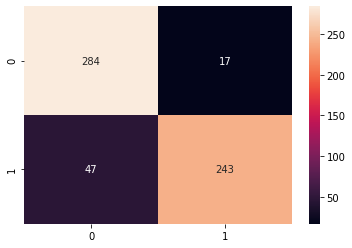

In [49]:
# confusion matrix:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt=".0f")

#### use pipeline on guessed band lyrics: 

In [50]:
clean_rf_pipe.predict_proba(["a long ride for someone"]) 

array([[0.62423776, 0.37576224]])

In [51]:
clean_rf_pipe.predict_proba(["my car"])

array([[0.66326048, 0.33673952]])

In [52]:
clean_rf_pipe.predict_proba(["float on float on float on"])

array([[0.59141675, 0.40858325]])

In [53]:
clean_rf_pipe.predict_proba(["nightmares"])

array([[0.53033066, 0.46966934]])

In [54]:
clean_rf_pipe.predict_proba(["getting together with you"])

array([[0.52902408, 0.47097592]])

In [55]:
print(clean_rf_pipe.predict_proba(["jaksfnaksljdbflasdkjf"]))

[[0.53699813 0.46300187]]


In [56]:
print(clean_rf_pipe.predict_proba(["float on float on float on float on float on float on float on float on float on"]))

[[0.59141675 0.40858325]]


In [57]:
print(clean_rf_pipe.predict_proba(["like a blister in the sun"]))
print("\N{pouting face}")

[[0.504554 0.495446]]
😡


In [58]:
print(clean_rf_pipe.predict_proba(["blister blister blister"]))
print("\N{pouting face}")

[[0.51899321 0.48100679]]
😡
